In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from markov import *
from base_models import *
from pos_encoder import *
from causal_graph import *
from config import *
from train import *
import plot
from util import memory_recall_probe, feedforward_probe
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from head_view import *

%load_ext autoreload
%autoreload 2

## Fixed Random Markov Chain

In [2]:
SEQ_LEN = 100
VOC_SIZE = 3
BATCH_SIZE = 256

config = Config(
        emb_dim=128,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=2000,
        eval_iter=20,
        pos_enc='rpe',
        get_attn=100,
        mlp=(True,False),
        activation=(True,False),
        flash=False,
        ff_dim=128,
        layer_norm=False,
        ngram=2,
        learning_rate=1e-3,
        task_name="icl-frm"
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, rho=0.2,
                                     task_name="icl-frm")

model = Transformer(config)
model = model.to(config.device)

config.device

'cuda'

Random rows: tensor([4])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss plot saved at  loss_plots/s100p_rpe_l2h1_1v3icl-frm_20250213_0024.png


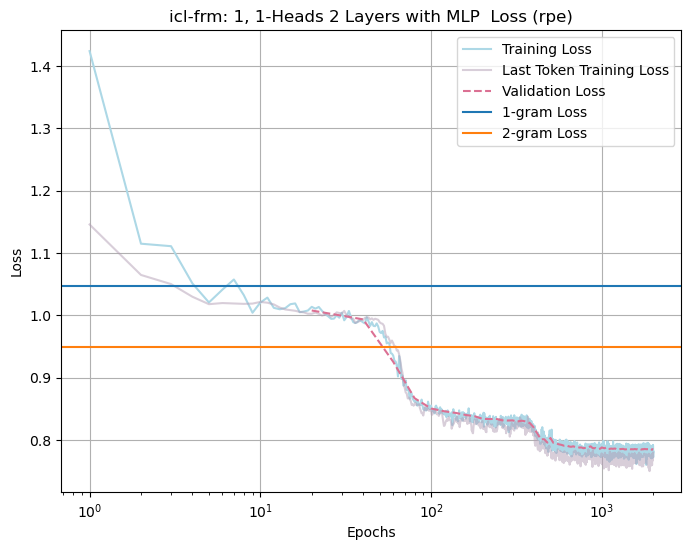

Creating images:   0%|          | 0/20 [00:00<?, ?it/s]

GIF saved at attns_plot/s100p_rpe_l2h1v3_L0H0icl-frm_20250213_0024.gif
Folder 'attns' and its contents removed.


Creating images:   0%|          | 0/20 [00:00<?, ?it/s]

GIF saved at attns_plot/s100p_rpe_l2h1v3_L1H0icl-frm_20250213_0024.gif
Folder 'attns' and its contents removed.


,


In [3]:
train_model_with_plot(model, config, sampler_config, show=True)

In [14]:
SEQ_LEN = 100
VOC_SIZE = 8
BATCH_SIZE = 64

config = Config(
        emb_dim=128,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=60000,
        eval_iter=2000,
        pos_enc='rpe',
        get_attn=1000,
        mlp=(True,False),
        activation=(True,False),
        flash=False,
        ff_dim=128,
        layer_norm=False,
        ngram=2,
        learning_rate=1e-3,
        task_name="icl-frm"
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, rho=1, order=1,
                                     task_name="icl-frm")

model = Transformer(config)
model = model.to(config.device)

config.device

'cuda'

Random rows: tensor([5, 7, 2, 1, 4, 6, 0, 3])


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss plot saved at  loss_plots/s100p_rpe_l2h1_1v8icl-frm_20250213_0122.png


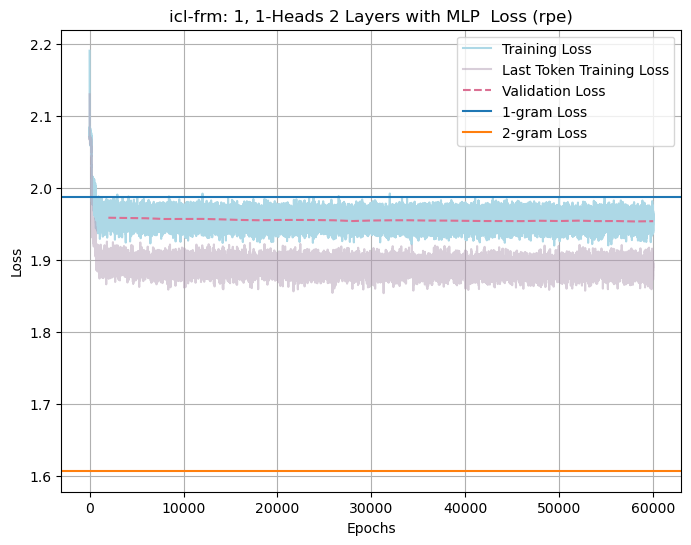

Creating images:   0%|          | 0/60 [00:00<?, ?it/s]

GIF saved at attns_plot/s100p_rpe_l2h1v8_L0H0icl-frm_20250213_0122.gif
Folder 'attns' and its contents removed.


Creating images:   0%|          | 0/60 [00:00<?, ?it/s]

GIF saved at attns_plot/s100p_rpe_l2h1v8_L1H0icl-frm_20250213_0122.gif
Folder 'attns' and its contents removed.


,


In [15]:
train_model_with_plot(model, config, sampler_config, show=True, log=False)

## Causal Graphs

In [80]:
SEQ_LEN = 32
VOC_SIZE = 3
BATCH_SIZE = 256

config = Config(
        emb_dim=128,
        num_layers=2,
        num_heads=(2,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=2000,
        eval_iter=20,
        pos_enc='abs',
        get_attn=100,
        mlp=(False,False),
        activation=(False,False),
        flash=False,
        ff_dim=128,
        layer_norm=False,
        ngram=False,
        learning_rate=1e-3,
        task_name="dag"
    )

dag = [[], []] + [[(i - 1) // 2, i - 1] for i in range(2, SEQ_LEN + 1)]
# dag = get_random_DAG(SEQ_LEN, p=0.1)
sampler_config = CausalGraphConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, 
                                   dag=dag, task_name="dag")

model = Transformer(config)
model = model.to(config.device)

config.device

'cuda'

### Training

In [81]:
train_results = train_model(model, config, sampler_config)

Dataset Size: 130.86 MB


  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
train_results = train_model(model, config, sampler_config)

Dataset Size: 52.34 MB


  0%|          | 0/800 [00:00<?, ?it/s]

### Training Loss Plots

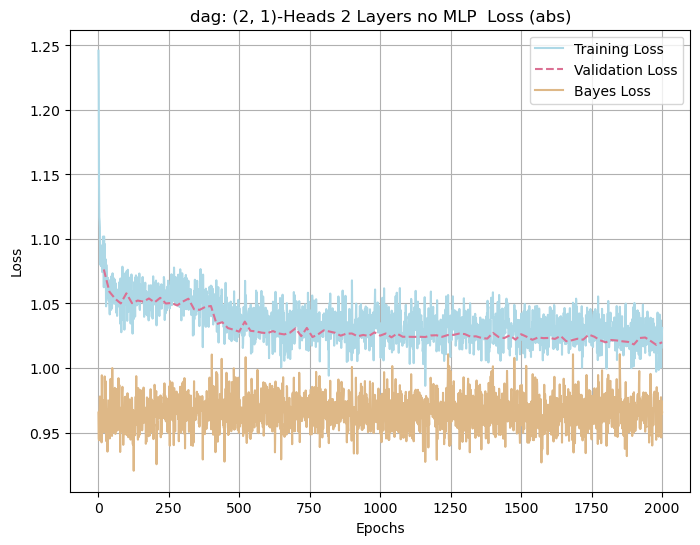

In [82]:
plot.get_loss_plots(config, train_results)

### Attention Plots

In [83]:
plot.get_attn_gif(layer=0,head="both",train_results=train_results,dag=sampler_config.dag,config=config)

  0%|          | 0/20 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h2v3_L0Hbothdag_20250204_022032.gif
Folder 'attns' and its contents removed.


<img src="attns_plot/l2h2v3_L0Hbothdag_20250204_022032.gif" width="1000" align="center">

## Associate Memory

In [84]:
SEQ_LEN = 64
VOC_SIZE = 23
BATCH_SIZE = 512

config = Config(
        emb_dim=128,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=500,
        eval_iter=20,
        pos_enc='abs',
        get_attn=60,
        mlp=(True, True),
        activation=(False, False),
        flash=True,
        ff_dim=128,
        layer_norm=False,
        ngram=True,
        learning_rate=1e-3,
        task_name="bietti"
    )

sampler_config = BiettiSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, 
                                     k=3, show_mask=True, task_name="bietti")

model = Transformer(config).to(config.device)

In [86]:
train_results = train_model(model, config, sampler_config)

Dataset Size: 250.00 MB


  0%|          | 0/500 [00:00<?, ?it/s]

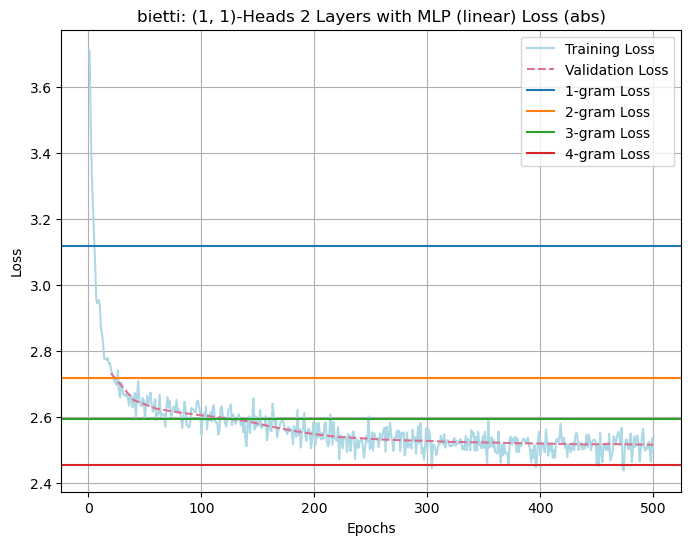

In [87]:
plot.get_loss_plots(config, train_results)

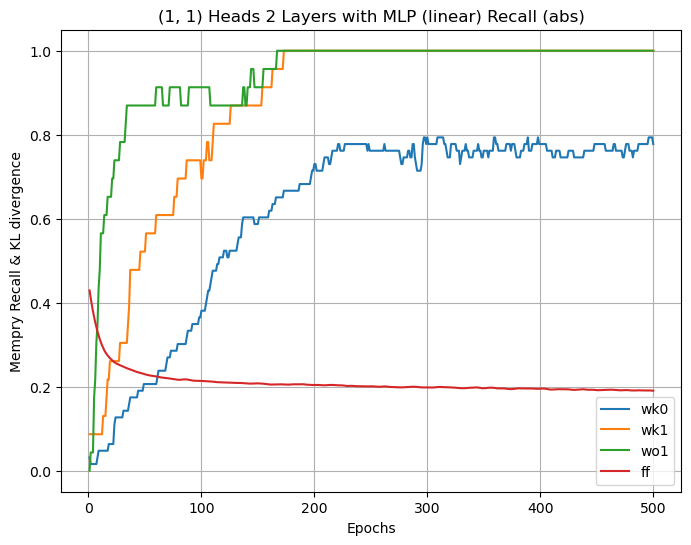

In [88]:
plot.plot_probes(train_results, config)

## Bigram Backcopy

In [89]:
SEQ_LEN = 64
VOC_SIZE = 23
BATCH_SIZE = 512

config = Config(
        emb_dim=128,
        num_layers=1,
        num_heads=(1,),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=500,
        eval_iter=20,
        pos_enc='abs',
        get_attn=10,
        mlp=(True,),
        activation=(False,),
        flash=True,
        ff_dim=128,
        layer_norm=False,
        ngram=True,
        learning_rate=1e-3,
        task_name="bb",
    )

sampler_config = BBSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, 
                                 batch_size=BATCH_SIZE, k=3, show_mask=True,task_name="bb",)

model = Transformer(config).to(config.device)

In [90]:
train_results = train_model(model, config, sampler_config)

Dataset Size: 250.00 MB


  0%|          | 0/500 [00:00<?, ?it/s]

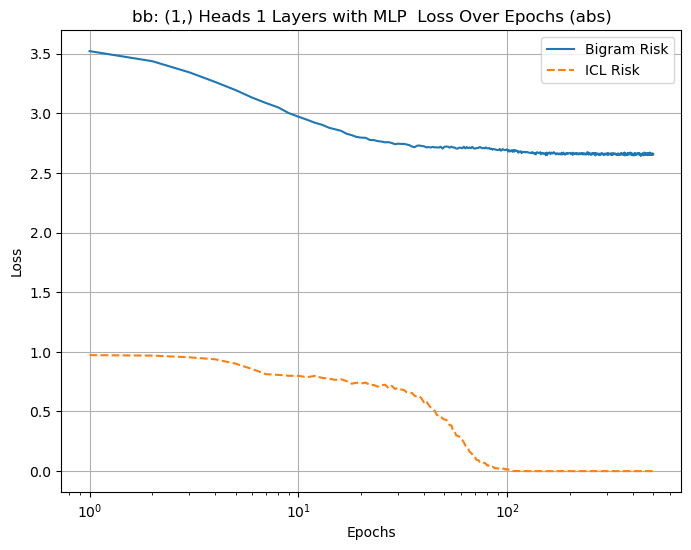

In [91]:
plot.plot_bigram_icl_risk(config, train_results)

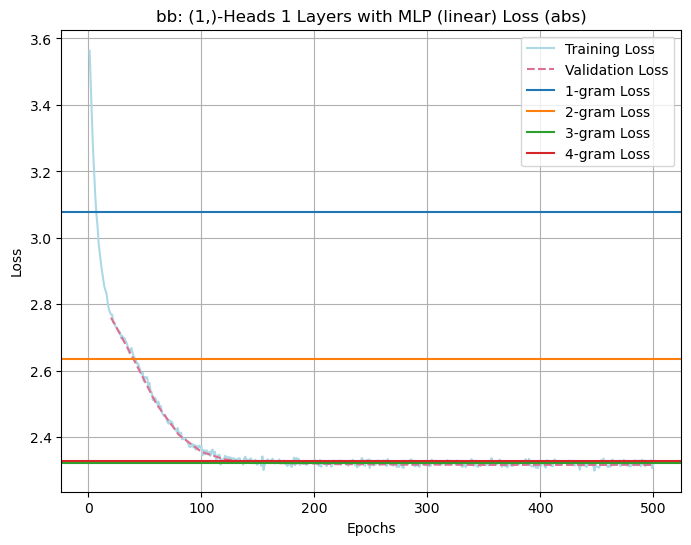

In [92]:
plot.get_loss_plots(config, train_results)

In [93]:
plot.get_attn_gif(layer=0,head=0,train_results=train_results,config=config)

  0%|          | 0/50 [00:00<?, ?it/s]

GIF saved at attns_plot/l1h1v23_L0H0bb_20250204_022403.gif
Folder 'attns' and its contents removed.


<img src="attns_plot/l1h1v23_L0H0bb_20250204_022403.gif" width="800" align="center">

## ICL-MC Order-1

In [106]:
SEQ_LEN = 60
VOC_SIZE = 3
BATCH_SIZE = 64

config = Config(
        emb_dim=32,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=10000,
        eval_iter=500,
        pos_enc='rpe',
        pos_max_len=100,
        get_attn=100,
        mlp=(False,False),
        activation=(False,False),
        flash=False,
        ff_dim=32,
        layer_norm=False,
        ngram=2,
        learning_rate=2e-4,
        task_name='icl-mc',
        scheduler=False,
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, 
                                     order=1, task_name='icl-mc')

model = Transformer(config).to(config.device)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss plot saved at  loss_plots/l2h1_1v3icl-mc_20250204_224154.png


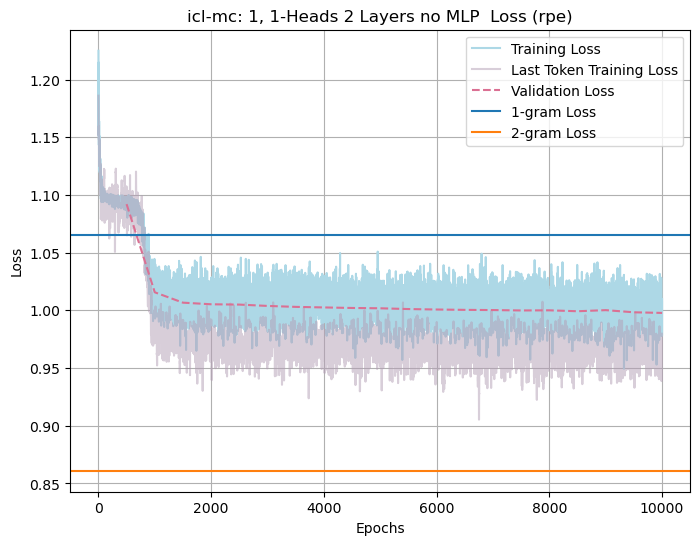

  0%|          | 0/100 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v3_L0H0icl-mc_20250204_224216.gif
Folder 'attns' and its contents removed.


  0%|          | 0/100 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v3_L1H0icl-mc_20250204_224239.gif
Folder 'attns' and its contents removed.


,


In [107]:
train_results = train_model_with_plot(model, config, sampler_config)

In [108]:
get_head_view(model, train_results, config, trunc=30)

<IPython.core.display.Javascript object>

torch.Size([1, 100])


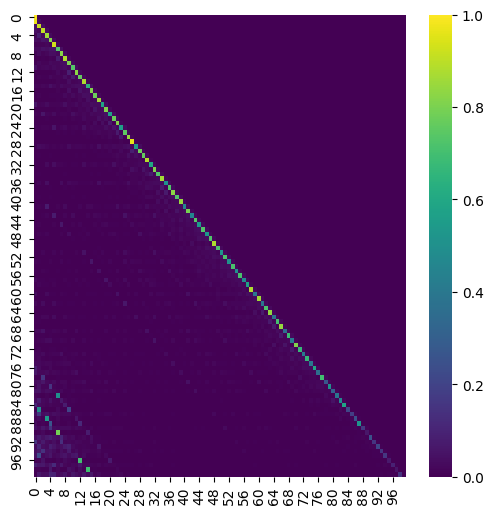

In [107]:
sampler = train_results['sampler']
batch = sampler.generate()[0][0][:1]
print(batch.shape)
_, attn_map = model(batch, get_attn=True)
plt.figure(figsize=(6, 6))
sns.heatmap(attn_map[0][0].cpu(), cmap="viridis", annot=False)
plt.show()

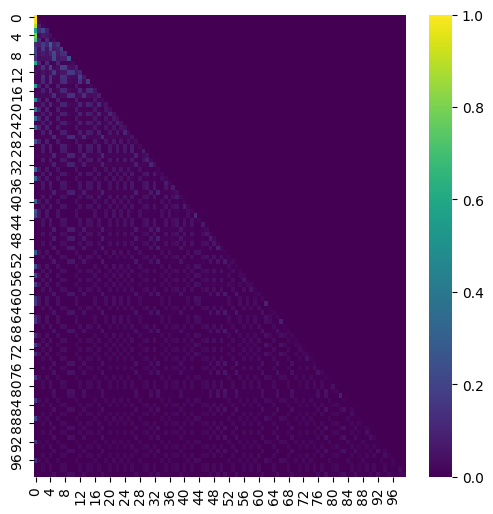

In [74]:
plt.figure(figsize=(6, 6))
sns.heatmap(attn_map[1][0].cpu(), cmap="viridis", annot=False)
plt.show()

In [75]:
sample = batch[0].cpu()
range_vec = torch.arange(sample.size(0))
ind = 50
target = range_vec[:ind][sample[:ind]==sample[ind]]+1
attn_target = attn_map[1][0][ind][:ind].cpu()
mask = ~torch.isin(range_vec[:ind], target)
attn_target[target].mean(), attn_target[mask].mean()

(tensor(0.0617), tensor(0.0076))

In [76]:
attn_target[target], attn_target[mask]

(tensor([0.0641, 0.0609, 0.0626, 0.0559, 0.0682, 0.0618, 0.0492, 0.0732, 0.0502,
         0.0444, 0.0880]),
 tensor([0.0029, 0.0065, 0.0082, 0.0063, 0.0105, 0.0057, 0.0090, 0.0085, 0.0066,
         0.0096, 0.0087, 0.0078, 0.0067, 0.0086, 0.0071, 0.0078, 0.0064, 0.0080,
         0.0068, 0.0079, 0.0061, 0.0073, 0.0072, 0.0101, 0.0072, 0.0076, 0.0079,
         0.0084, 0.0072, 0.0111, 0.0075, 0.0082, 0.0079, 0.0083, 0.0061, 0.0064,
         0.0085, 0.0062, 0.0063]))

In [77]:
sample[ind], sample[:ind][mask], sample[:ind][target]

(tensor(1),
 tensor([0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2,
         1, 1, 2, 0, 2, 2, 1, 0, 2, 0, 0, 2, 2, 1, 1]),
 tensor([0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2]))

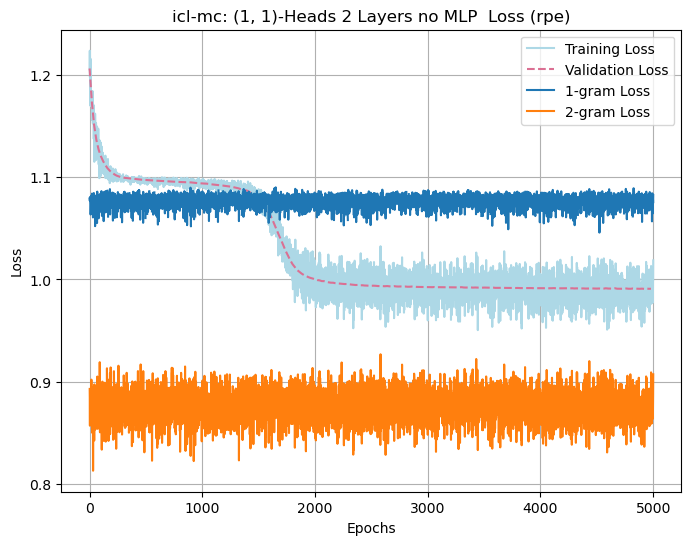

In [19]:
plot.get_loss_plots(config, train_results)

In [230]:
SEQ_LEN = 100
VOC_SIZE = 4
BATCH_SIZE = 64

config = Config(
        emb_dim=20,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=20000,
        eval_iter=500,
        pos_enc='rpe',
        pos_max_len=100,
        get_attn=50,
        mlp=(False,False),
        activation=(False,False),
        flash=False,
        ff_dim=20,
        layer_norm=False,
        ngram=2,
        learning_rate=2e-4,
        task_name='icl-mc',
        scheduler=False,
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, 
                                     order=1, task_name='icl-mc')

model = Transformer(config).to(config.device)

In [231]:
train_results = train_model(model, config, sampler_config) # M3 Pro, for small models, M3 Pro is faster than GPU. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

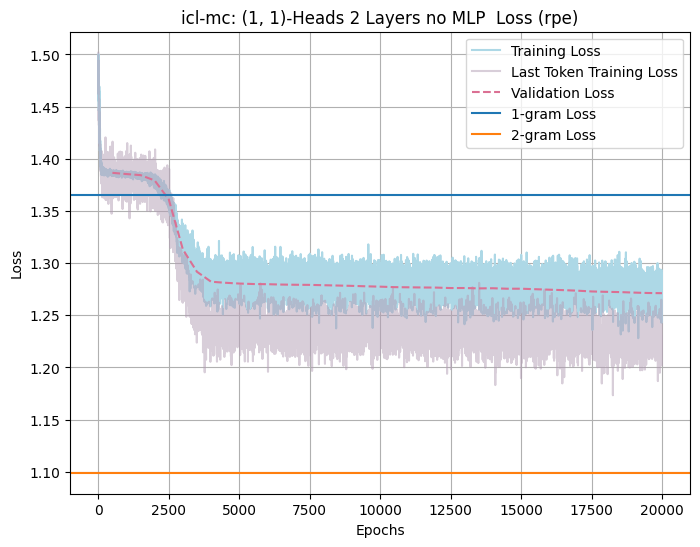

In [232]:
plot.get_loss_plots(config, train_results)

In [219]:
plot.get_attn_gif(layer=0,head=0,train_results=train_results,config=config)

  0%|          | 0/400 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v4_L0H0icl-mc_20250204_155246.gif
Folder 'attns' and its contents removed.


<img src="attns_plot/l2h1v4_L0H0icl-mc_20250204_155246.gif" width="600" align="center">

In [48]:
from head_view import *

sampler = train_results['sampler']
batch = sampler.generate()[0][0][:1]
_, attn_map = model(batch, get_attn=True)

trunc = 70
attn_tensors = [torch.zeros((1,config.num_heads[l],100,100)) for l in range(config.num_layers)]
for l, attn in attn_map.items():
    attn = attn.unsqueeze(0)  # Number of heads in this layer
    attn_tensors[l][:1, :config.num_heads[l], :, :] = attn  # Fill attention tensor

trunc_attn = [attn_tensors[l][:1, :config.num_heads[l], trunc:, trunc:] for l in range(config.num_layers)]
trunc_attn = [trunc_attn[l]/trunc_attn[l].sum(dim=-1, keepdims=True) for l in range(config.num_layers)]


In [85]:
head_view(trunc_attn, batch[0].tolist()[trunc:])

<IPython.core.display.Javascript object>

## Order-2 Markov Chain (Trigram)

In [13]:
SEQ_LEN = 64
VOC_SIZE = 5
BATCH_SIZE = 512

config = Config(
        emb_dim=128,
        num_layers=2,
        num_heads=(2,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=500,
        eval_iter=20,
        pos_enc='abs',
        get_attn=10,
        mlp=(False,False),
        activation=(False,False),
        flash=True,
        ff_dim=128,
        layer_norm=False,
        ngram=True,
        learning_rate=1e-3,
        task_name="markov"
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, 
                                     order=2, task_name="markov")

model = Transformer(config).to(config.device)

In [14]:
train_results = train_model(model, config, sampler_config)

  0%|          | 0/500 [00:00<?, ?it/s]

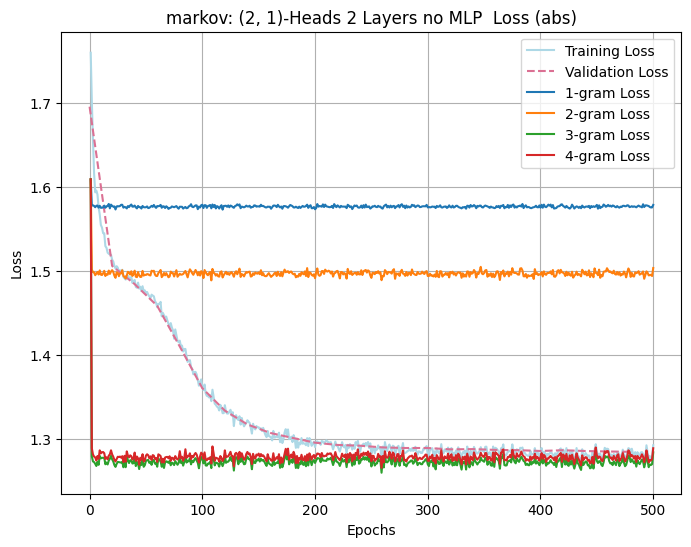

In [15]:
plot.get_loss_plots(config, train_results)

In [17]:
plot.get_attn_gif(layer=0,head='all',train_results=train_results,config=config)

Deleted: attns
GIF saved at attns_plot/l2h2v5_L0Hallmarkov_20250203_161908.gif
Folder 'attns' and its contents removed.


<img src="attns_plot/l2h2v5_L0Hallmarkov_20250130_194437.gif" width="1000" align="center">

In [12]:
plot.get_attn_gif(layer=1,head=0,train_results=train_results,task_name="markov",config=config)

GIF saved at attns_plot/l2h1v5_L1H0markov_20250130_194705.gif
Folder 'attns' and its contents removed.


<img src="attns_plot/l2h1v5_L1H0markov_20250130_194705.gif" width="600" align="center">

## Order-3 Markov Chain (4-gram)

In [22]:
SEQ_LEN = 64
VOC_SIZE = 3
BATCH_SIZE = 512

config = Config(
        emb_dim=64*3,
        num_layers=2,
        num_heads=(3,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=2000,
        eval_iter=20,
        pos_enc='abs',
        get_attn=10,
        mlp=(False,False),
        activation=(False,False),
        flash=True,
        ff_dim=64*3,
        layer_norm=False,
        ngram=True,
        learning_rate=1e-3,
        task_name="markov"
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, 
                                     order=3, task_name="markov")

model = Transformer(config).to(config.device)

In [23]:
train_results = train_model(model, config, sampler_config)

100%|██████████| 2000/2000 [03:34<00:00,  9.34it/s]


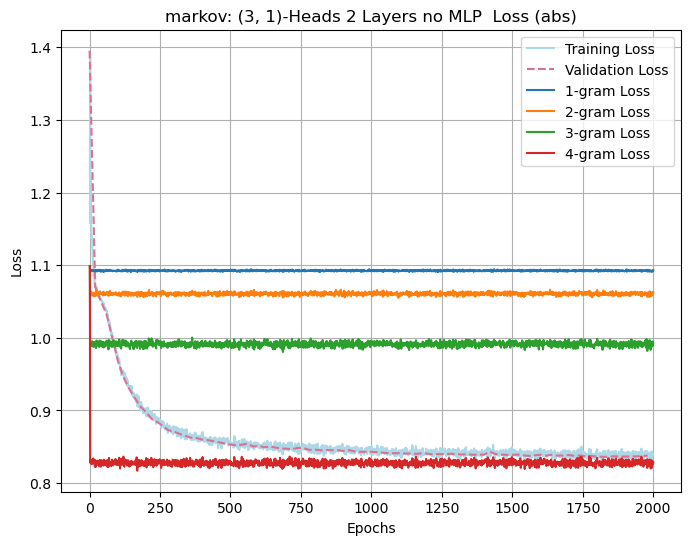

In [24]:
plot.get_loss_plots(config, train_results)

In [ ]:
plot.get_attn_gif(layer=0,head='all',train_results=train_results,config=config)

<img src="attns_plot/l2h3v3_L0Hallmarkov_20250130_200657.gif" width="1200" align="center">

In [26]:
plot.get_attn_gif(layer=1,head=0,train_results=train_results,config=config)

Deleted: attns
GIF saved at attns_plot/l2h1v3_L1H0markov_20250130_200912.gif
Folder 'attns' and its contents removed.


<img src="attns_plot/l2h1v5_L1H0markov_20250130_195108.gif" width="600" align="center">

### A Little Runtime Benchmark

Generating long Markovian sequence could be costly. To effectively utilize gpu, we recommend to run larger `batch_size` with smaller `seq_len`. 

In [5]:
## This is run on a M3 Pro macbook pro

vocab_size = 10
seq_len = 100
batch_size = 4096

torch_args = MarkovSamplerConfig(vocab_size=vocab_size, batch_size=batch_size, seq_len=seq_len, order=1, device='cpu')
torch_ds = MarkovSampler(torch_args)

# Benchmark CPU execution
timer_cpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="CPU"
)
result_cpu = timer_cpu.timeit(200)
print(result_cpu)

Dataset Generation: CPU
  54.16 ms
  1 measurement, 200 runs , 1 thread


In [8]:
## This is run on a Intel Ultra 9 185H

vocab_size = 10
seq_len = 100
batch_size = 4096

torch_args = MarkovSamplerConfig(vocab_size=vocab_size, batch_size=batch_size, seq_len=seq_len, order=1, device='cpu')
torch_ds = MarkovSampler(torch_args)

# Benchmark CPU execution
timer_cpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="CPU"
)
result_cpu = timer_cpu.timeit(200)
print(result_cpu)

Dataset Generation: CPU
  66.46 ms
  1 measurement, 200 runs , 1 thread


In [9]:
## This is run on a RTX 3090Ti 

trans_mat = torch_ds.trans_matrix.to("cuda")
torch_args = MarkovSamplerConfig(vocab_size=vocab_size, batch_size=batch_size, seq_len=seq_len, order=1, device='cuda')
torch_ds = MarkovSampler(torch_args)
torch_ds.trans_mat = trans_mat

# Benchmark GPU execution
timer_gpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="GPU"
)
result_gpu = timer_gpu.timeit(200)
print(result_gpu)

Dataset Generation: GPU
  29.91 ms
  1 measurement, 200 runs , 1 thread


GPU has a `2x` speedup compared to CPU.

In [6]:
## This is run on a M3 Pro macbook pro

torch_args = MarkovSamplerConfig(vocab_size=vocab_size, batch_size=batch_size, seq_len=seq_len, order=1, device='cpu')
torch_ds = ICLMarkovSampler(torch_args)

# Benchmark CPU execution
timer_cpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="CPU"
)
result_cpu = timer_cpu.timeit(200)
print(result_cpu)

Dataset Generation: CPU
  66.62 ms
  1 measurement, 200 runs , 1 thread


In [10]:
## This is run on a Intel Ultra 9 185H

torch_args = MarkovSamplerConfig(vocab_size=vocab_size, batch_size=batch_size, seq_len=seq_len, order=1, device='cpu')
torch_ds = ICLMarkovSampler(torch_args)

# Benchmark CPU execution
timer_cpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="CPU"
)
result_cpu = timer_cpu.timeit(200)
print(result_cpu)

Dataset Generation: CPU
  85.42 ms
  1 measurement, 200 runs , 1 thread


In [11]:
torch_args = MarkovSamplerConfig(vocab_size=vocab_size, batch_size=batch_size, seq_len=seq_len, order=1, device='cuda')
torch_ds = ICLMarkovSampler(torch_args)

# Benchmark GPU execution
timer_gpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="GPU"
)
result_gpu = timer_gpu.timeit(200)
print(result_gpu)

Dataset Generation: GPU
  30.28 ms
  1 measurement, 200 runs , 1 thread


#### Use `torch.jit.script()`

`torch.jit.script()` does not support user-defined classes, so we will directly create the transition matrix and pass it to a jitted function.

In [12]:
# Define benchmark timer
t = benchmark.Timer(
    stmt="markov_generate_jitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)",
    globals={"markov_generate_jitted": markov_generate_jitted, 
             "trans_matrix": trans_mat,
             "batch_size": batch_size,
             "seq_len": seq_len,
             "vocab_size": vocab_size,
             "order": 1,
             "device": "cuda"}
)

# Run the benchmark multiple times
result = t.timeit(200) 

print(result)

markov_generate_jitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)
  25.40 ms
  1 measurement, 200 runs , 1 thread


In [13]:
# Define benchmark timer
t = benchmark.Timer(
    stmt="markov_generate_unjitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)",
    globals={"markov_generate_unjitted": markov_generate_unjitted, 
             "trans_matrix": trans_mat,
             "batch_size": batch_size,
             "seq_len": seq_len,
             "vocab_size": vocab_size,
             "order": 1,
             "device": "cuda"}
)

# Run the benchmark multiple times
result = t.timeit(200)

print(result)

markov_generate_unjitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)
  29.29 ms
  1 measurement, 200 runs , 1 thread


In [14]:
trans_mat = trans_mat.to('cpu')

# Define benchmark timer
t = benchmark.Timer(
    stmt="markov_generate_jitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)",
    globals={"markov_generate_jitted": markov_generate_jitted, 
             "trans_matrix": trans_mat,
             "batch_size": batch_size,
             "seq_len": seq_len,
             "vocab_size": vocab_size,
             "order": 1,
             "device": "cpu"}
)

# Run the benchmark multiple times
result = t.timeit(200)

print(result)

markov_generate_jitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)
  63.54 ms
  1 measurement, 200 runs , 1 thread


In [16]:
# Define benchmark timer
t = benchmark.Timer(
    stmt="markov_generate_unjitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)",
    globals={"markov_generate_unjitted": markov_generate_unjitted, 
             "trans_matrix": trans_mat,
             "batch_size": batch_size,
             "seq_len": seq_len,
             "vocab_size": vocab_size,
             "order": 1,
             "device": "cpu"}
)

# Run the benchmark multiple times
result = t.timeit(200)

print(result)

markov_generate_unjitted(trans_matrix, batch_size, seq_len, vocab_size, order, device)
  64.81 ms
  1 measurement, 200 runs , 1 thread


The jitted code makes a small improvement. It is less big a deal, so we will stick with the class implementation for cleaner code.

### More comparisons on other tasks

In [2]:
## This is run on a RTX 3090Ti 
SEQ_LEN = 64
VOC_SIZE = 23
BATCH_SIZE = 512

torch_args = BBSamplerConfig(vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, seq_len=SEQ_LEN, 
                              k=3, show_mask=True, device='cuda')
torch_ds = BBTask(torch_args)

# Benchmark GPU execution
timer_gpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="GPU"
)
result_gpu = timer_gpu.timeit(200)
print(result_gpu)

Dataset Generation: GPU
  41.52 ms
  1 measurement, 200 runs , 1 thread


In [3]:
torch_args = BBSamplerConfig(vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, seq_len=SEQ_LEN, 
                              k=3, show_mask=True, device='cpu')
torch_ds = BBTask(torch_args)

# Benchmark CPU execution
timer_cpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="CPU"
)
result_cpu = timer_cpu.timeit(200)
print(result_cpu)

Dataset Generation: CPU
  15.85 ms
  1 measurement, 200 runs , 1 thread


In [3]:
## This is run on M3 Pro
SEQ_LEN = 64
VOC_SIZE = 23
BATCH_SIZE = 512

torch_args = BBSamplerConfig(vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, seq_len=SEQ_LEN, 
                              k=3, show_mask=True, device='cpu')
torch_ds = BBTask(torch_args)

# Benchmark CPU execution
timer_cpu = benchmark.Timer(
    stmt="torch_ds.generate()",
    globals={"torch_ds": torch_ds},  
    label="Dataset Generation",
    sub_label="CPU"
)
result_cpu = timer_cpu.timeit(200)
print(result_cpu)

Dataset Generation: CPU
  9.35 ms
  1 measurement, 200 runs , 1 thread


GPU is bad at handling small tasks. For Markov-based tasks, the bottleneck is generating data. 